In [1]:
# Typing
from typing import Tuple

# Core
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import timedelta

# SciPy
from scipy.stats import norm
from scipy.stats.qmc import Sobol, Halton
from scipy.optimize import fsolve

# Display / Plot
from tabulate import tabulate
import matplotlib.pyplot as plt
import cufflinks as cf
cf.set_config_file(offline=True)


In [2]:
class BS:
    
    """
    This is a class for Options contract for pricing European options on stocks/index without dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
        callprice     : int or float [default None]
        putprice      : int or float [default None]
    """    
    
    def __init__(self, spot, strike, rate, dte, volatility, callprice=None, putprice=None):
        
        # Spot Price
        self.spot = spot
        
        # Option Strike
        self.strike = strike
        
        # Interest Rate
        self.rate = rate
        
        # Days To Expiration
        self.dte = dte
        
        # Volatlity
        self.volatility = volatility
        
        # Callprice
        self.callprice = callprice
        
        # Putprice
        self.putprice = putprice
            
        # Utility 
        self._a_ = self.volatility * self.dte**0.5
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (np.log(self.spot / self.strike) + \
                     (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_
        
        self._d2_ = self._d1_ - self._a_
        
        self._b_ = np.e**-(self.rate * self.dte)
        
        
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', \
                  'callRho', 'putRho', 'vega', 'gamma', 'impvol']:
            self.__dict__[i] = None
        
        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()
        self.impvol = self._impvol()
    
    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.dte == 0:
            call = np.maximum(0.0, self.spot - self.strike)
            put = np.maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * np.e**(-self.rate * \
                                                                       self.dte) * norm.cdf(self._d2_)

            put = self.strike * np.e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                                                                        self.spot * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        '''Returns the option gamma'''
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100

    # Option Theta
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100

        return [call, put]
    
    # Option Implied Volatility
    def _impvol(self):
        '''Returns the option implied volatility'''
        if (self.callprice or self.putprice) is None:
            return self.volatility
        else:
            def f(sigma):
                option = BS(self.spot,self.strike,self.rate,self.dte,sigma)
                if self.callprice:
                    return option.callPrice - self.callprice
                if self.putprice and not self.callprice:
                    return option.putPrice - self.putprice

            return np.maximum(1e-5, fsolve(f, 0.2)[0])

In [3]:
class GBMSobolSimulator:
    def __init__(self, S0, r, sigma, T=1, N=100, n_paths=1024, scramble=True):
        """
        初始化 Geometric Brownian Motion (GBM) 模拟器，使用 Sobol 低差异序列。
        
        Parameters:
        - S0: 初始价格
        - r: 无风险利率
        - sigma: 年化波动率
        - T: 到期时间（年）
        - N: 时间步数
        - n_paths: 模拟路径数
        - scramble: 是否使用 scrambling（regularity breaking）
        """
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = T
        self.N = N
        self.n_paths = n_paths
        self.scramble = scramble
        self.dt = T / N
        self.paths = None  # 存储模拟结果

    def simulate_paths(self):
        """执行路径模拟，保存在 self.paths"""
        # Step 1: 使用 Sobol 生成 U[0,1] 的低差异采样
        sobol = Sobol(d=self.N, scramble=self.scramble)
        u = sobol.random(n=self.n_paths)

        # Step 2: 转换为正态分布变量
        Z = norm.ppf(u)

        # Step 3: 初始化路径数组
        paths = np.zeros((self.n_paths, self.N + 1))
        paths[:, 0] = self.S0

        # Step 4: 迭代生成路径
        drift = (self.r - 0.5 * self.sigma ** 2) * self.dt
        diffusion_scale = self.sigma * np.sqrt(self.dt)

        for t in range(1, self.N + 1):
            diffusion = diffusion_scale * Z[:, t - 1]
            paths[:, t] = paths[:, t - 1] * np.exp(drift + diffusion)

        self.paths = paths
        return paths\
        
    def get_path_dataframe(self, path_index=0, label="Asset Path (sigma_a)"):
        """
        获取某一条资产路径作为 pandas DataFrame。
        
        Parameters:
        - path_index: 第几条路径（默认是第 0 条）
        - label: Asset Path 的列名（默认："Asset Path (sigma_a)"）

        Returns:
        - pd.DataFrame，含 'Time' 和指定资产路径列
        """
        if self.paths is None:
            raise ValueError("You must call simulate_paths() first.")
        if path_index >= self.n_paths:
            raise IndexError(f"path_index must be < {self.n_paths}")

        time_grid = np.linspace(0, self.T, self.N + 1)
        path_series = self.paths[path_index]

        df = pd.DataFrame({
            "Time": time_grid,
            label: path_series
        })

        return df

    def plot_paths(self, n_plot=10):
        """可视化模拟路径（默认前10条）"""
        if self.paths is None:
            raise ValueError("You must call simulate_paths() first.")

        time_grid = np.linspace(0, self.T, self.N + 1)
        plt.figure(figsize=(10, 5))
        for i in range(min(n_plot, self.n_paths)):
            plt.plot(time_grid, self.paths[i], lw=1)
        plt.title("Quasi-Monte Carlo Simulated Asset Paths (Sobol)")
        plt.xlabel("Time (years)")
        plt.ylabel("Asset Price")
        plt.grid(True)
        plt.show()


In [4]:
S0 = 100
K = 100
SIGMA_I = 0.20
SIGMA_A = 0.25
R = 0.025

T = 1
N = 200
D_T = T/N
n_paths = 1024

using_Actual_Vol_to_Hedge = True

if using_Actual_Vol_to_Hedge:
    SIGMA_HEDGE = SIGMA_A
else:
    SIGMA_HEDGE = SIGMA_I


Value = BS(
        spot=S0,
        strike=K,
        rate=R,
        dte=T,
        volatility=SIGMA_A
    ).callPrice

Market_Price = BS(
        spot=S0,
        strike=K,
        rate=R,
        dte=T,
        volatility=SIGMA_I
    ).callPrice


theoretical_PL = Value-Market_Price

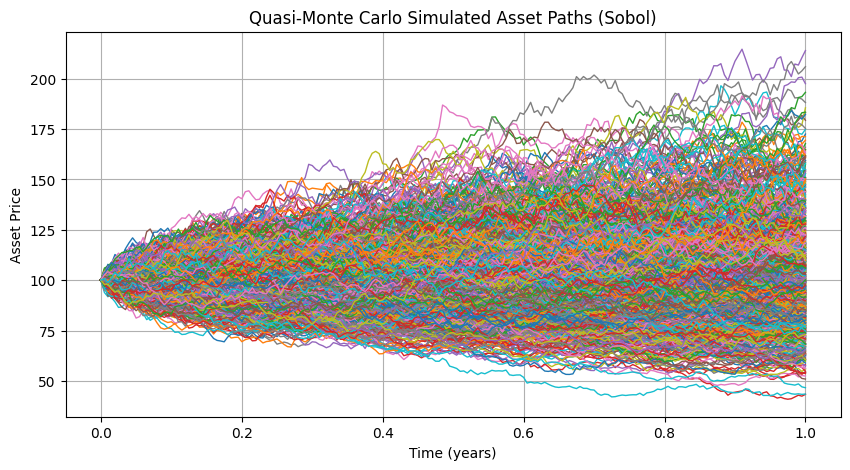

In [5]:
sim = GBMSobolSimulator(S0=S0, r=R, sigma=SIGMA_A, T=T, N=N, n_paths=n_paths, scramble=True)
paths = sim.simulate_paths()
sim.plot_paths(n_plot=1000)

In [6]:
df_path = sim.get_path_dataframe(path_index=5)  # 获取第1条路径



# data = {
#     "Time": [
#         0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045,
#         0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095,
#         0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145
#     ],
#     "Asset Path (sigma_a)": [
#         100.00, 102.00, 102.61, 100.51, 101.07, 101.19, 103.04, 104.47, 102.26, 100.03,
#         101.77, 105.80, 107.58, 107.91, 110.08, 108.93, 107.72, 107.94, 111.06, 113.26,
#         117.06, 119.34, 119.57, 119.15, 118.31, 119.31, 117.30, 118.39, 116.32, 115.84
#     ]
# }

# df_path = pd.DataFrame(data)

In [7]:
class DeltaHedgeAnalyzer:
    """
    Wraps:
      - Option valuation under implied vs hedge vol
      - Delta-hedge replication cashflows & cash account
      - Gamma and realized–implied P&L diagnostics
      - Plots matching your current style

    Requirements
    ------------
    - BS: a class with properties .callPrice, .callDelta, .gamma
    - df_path: DataFrame with columns ["Time", "Asset Path (sigma_a)"]
    """

    def __init__(
        self,
        df_path: pd.DataFrame,
        *,
        S0: float = 100.0,
        K: float = 100.0,
        SIGMA_I: float = 0.20,
        SIGMA_A: float = 0.25,
        R: float = 0.025,
        T: float = 1.0,
        N: int = 200,
        n_paths: int = 1024,
        using_Actual_Vol_to_Hedge: bool = True
    ):
        self.df = df_path.copy()
        self.S0 = S0
        self.K = K
        self.SIGMA_I = SIGMA_I
        self.SIGMA_A = SIGMA_A
        self.R = R
        self.T = T
        self.N = N
        self.n_paths = n_paths
        self.D_T = T / N
        self.SIGMA_HEDGE = SIGMA_A if using_Actual_Vol_to_Hedge else SIGMA_I

        # Scalars for theoretical P&L at t=0 (BS fair values)
        self.Value = None
        self.Market_Price = None
        self.theoretical_PL = None

    # ---------- Core computations ----------
    def _compute_option_and_delta_columns(self):
        K, R, SIGMA_I = self.K, self.R, self.SIGMA_I
        SIGMA_HEDGE = self.SIGMA_HEDGE

        # Option value using implied vol (pricing)
        self.df['Option_sigma_i'] = self.df.apply(
            lambda r: BS(
                spot=r['Asset Path (sigma_a)'],
                strike=K,
                rate=R,
                dte=max(0.0, 1.0 - r['Time']),
                volatility=SIGMA_I
            ).callPrice,
            axis=1
        )

        # Delta under hedge vol (replicating)
        self.df['Delta_Replicating_Vol'] = self.df.apply(
            lambda r: BS(
                spot=r['Asset Path (sigma_a)'],
                strike=K,
                rate=R,
                dte=max(0.0, 1.0 - r['Time']),
                volatility=SIGMA_HEDGE
            ).callDelta,
            axis=1
        )

        # Portfolio = long option (implied vol) - delta * spot
        self.df["Portfolio"] = (
            self.df["Option_sigma_i"] - self.df["Delta_Replicating_Vol"] * self.df["Asset Path (sigma_a)"]
        )

    def _compute_cashflows_and_cash_account(self):
        R, D_T = self.R, self.D_T

        # Cashflow from replication = ΔDelta * Spot
        self.df["dDelta_Replicating_Vol"] = self.df["Delta_Replicating_Vol"].diff()
        self.df["Cashflow_from_Replication"] = self.df["dDelta_Replicating_Vol"] * self.df["Asset Path (sigma_a)"]

        # First row = 0
        first_idx = self.df.index[0]
        self.df.loc[first_idx, "Cashflow_from_Replication"] = 0.0
        self.df.drop(columns=["dDelta_Replicating_Vol"], inplace=True)

        # Cash on account recursion
        self.df["Cash_on_account"] = np.nan
        self.df.loc[first_idx, "Cash_on_account"] = -self.df.loc[first_idx, "Portfolio"]

        for t in range(1, len(self.df)):
            self.df.loc[self.df.index[t], "Cash_on_account"] = (
                self.df.loc[self.df.index[t], "Cashflow_from_Replication"]
                + self.df.loc[self.df.index[t-1], "Cash_on_account"] * np.exp(R * D_T)
            )

        # Cumulative P&L of the hedge
        self.df["PL_cumulative"] = self.df["Portfolio"] + self.df["Cash_on_account"]

    def _compute_gamma_and_realized_implied(self):
        K, R, SIGMA_HEDGE = self.K, self.R, self.SIGMA_HEDGE
        D_T = self.D_T

        # Gamma under hedge vol
        self.df['Gamma'] = self.df.apply(
            lambda r: BS(
                spot=r['Asset Path (sigma_a)'],
                strike=K,
                rate=R,
                dte=max(0.0, 1.0 - r['Time']),
                volatility=SIGMA_HEDGE
            ).gamma,
            axis=1
        )

        # Asset returns
        self.df["Asset_Return"] = self.df["Asset Path (sigma_a)"].pct_change()
        self.df.loc[self.df.index[0], "Asset_Return"] = np.nan

        # Indicator: made money if r^2 < sigma^2 * dt under short gamma (sign chosen to mirror your code)
        self.df["Made Money? r^2 < vol"] = np.where(
            self.df["Asset_Return"]**2 < (SIGMA_HEDGE**2 * D_T),
            -1,
            1
        )
        self.df.loc[self.df.index[0], "Made Money? r^2 < vol"] = np.nan

        # Realized - implied variance P&L approximation (gamma-scaled)
        self.df["P&L Realized-Implied"] = (
            0.5
            * self.df["Gamma"]
            * (self.df["Asset Path (sigma_a)"] ** 2)
            * (self.df["Asset_Return"] ** 2 - SIGMA_HEDGE**2 * D_T)
        )

    def _compute_theoretical_pl(self):
        # t=0 BS values using "actual" vs "implied" vol (as per your variables)
        self.Value = BS(
            spot=self.S0,
            strike=self.K,
            rate=self.R,
            dte=self.T,
            volatility=self.SIGMA_A
        ).callPrice

        self.Market_Price = BS(
            spot=self.S0,
            strike=self.K,
            rate=self.R,
            dte=self.T,
            volatility=self.SIGMA_I
        ).callPrice

        self.theoretical_PL = self.Value - self.Market_Price

        # Discounted actual replication P&L from cumulative portfolio value
        self.Actual_PL = np.exp(-self.R * self.T) * self.df["PL_cumulative"].iloc[-1]
        
    # ---------- Public API ----------
    def run(self):
        """Compute all columns + theoretical PL. Returns the enriched DataFrame."""
        self._compute_option_and_delta_columns()
        self._compute_cashflows_and_cash_account()
        self._compute_gamma_and_realized_implied()
        self._compute_theoretical_pl()
        return self.df

    # ---------- Plots (match your current styling) ----------
    def plot_asset_vs_pl(self, figsize=(8, 4.5)):
        fig, ax1 = plt.subplots(figsize=figsize)

        # Asset path in blue
        ax1.plot(self.df["Time"], self.df["Asset Path (sigma_a)"], color="blue", label="Asset Path (sigma_a)")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Asset Path (sigma_a)", color="blue")
        ax1.tick_params(axis='y', labelcolor="blue")

        # P&L cumulative in red (twin axis)
        ax2 = ax1.twinx()
        ax2.plot(self.df["Time"], self.df["PL_cumulative"], color="red", label="P&L cumulative")
        ax2.set_ylabel("P&L cumulative", color="red")
        ax2.tick_params(axis='y', labelcolor="red")

        # Legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

        plt.title("Asset Path vs. P&L cumulative")
        plt.tight_layout()
        plt.show()

    def plot_asset_vs_gamma(self, figsize=(7, 4)):
        fig, ax1 = plt.subplots(figsize=figsize)

        # Asset Path (left)
        ax1.plot(self.df["Time"], self.df["Asset Path (sigma_a)"], color="navy", label="Asset Path (sigma_a)")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Asset Path (sigma_a)", color="navy")
        ax1.tick_params(axis='y', labelcolor="navy")

        # Gamma (right)
        ax2 = ax1.twinx()
        if "Gamma" in self.df.columns:
            ax2.plot(self.df["Time"], self.df["Gamma"], color="brown", label="Gamma")
            ax2.set_ylabel("Gamma", color="brown")
            ax2.tick_params(axis='y', labelcolor="brown")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

        plt.title("Asset Path vs. Gamma")
        plt.tight_layout()
        plt.show()

    def plot_realized_implied_vs_gamma(self, figsize=(7, 4)):
        fig, ax1 = plt.subplots(figsize=figsize)

        # Realized-Implied P&L (left)
        if "P&L Realized-Implied" in self.df.columns:
            ax1.plot(self.df["Time"], self.df["P&L Realized-Implied"], color="steelblue", label="P&L Realized-Implied")
            ax1.set_xlabel("Time")
            ax1.set_ylabel("P&L Realized-Implied", color="steelblue")
            ax1.tick_params(axis='y', labelcolor="steelblue")

        # Gamma (right)
        ax2 = ax1.twinx()
        if "Gamma" in self.df.columns:
            ax2.plot(self.df["Time"], self.df["Gamma"], color="brown", label="Gamma")
            ax2.set_ylabel("Gamma", color="brown")
            ax2.tick_params(axis='y', labelcolor="brown")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

        plt.title("P&L Realized-Implied vs. Gamma")
        plt.tight_layout()
        plt.show()



In [9]:
# df_path must already exist and contain columns:
#   ["Time", "Asset Path (sigma_a)"]
# S0, K, SIGMA_I, SIGMA_A, R, T, N, n_paths, using_Actual_Vol_to_Hedge should be defined.


# data = {
#     "Time": [
#         0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045,
#         0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095,
#         0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145
#     ],
#     "Asset Path (sigma_a)": [
#         100.00, 102.00, 102.61, 100.51, 101.07, 101.19, 103.04, 104.47, 102.26, 100.03,
#         101.77, 105.80, 107.58, 107.91, 110.08, 108.93, 107.72, 107.94, 111.06, 113.26,
#         117.06, 119.34, 119.57, 119.15, 118.31, 119.31, 117.30, 118.39, 116.32, 115.84
#     ]
# }

# df_path = pd.DataFrame(data)


analyzer = DeltaHedgeAnalyzer(
    df_path,
    S0=S0, K=K, SIGMA_I=SIGMA_I, SIGMA_A=SIGMA_A,
    R=R, T=T, N=N, n_paths=n_paths,
    using_Actual_Vol_to_Hedge=using_Actual_Vol_to_Hedge
)
df_out = analyzer.run()


In [10]:
analyzer.theoretical_PL, analyzer.Actual_PL

(np.float64(1.9452591687397103), np.float64(1.7221289289757595))

In [14]:
df_out.head(2)

,Time,Asset Path (sigma_a),Option_sigma_i,Delta_Replicating_Vol,Portfolio,Cashflow_from_Replication,Cash_on_account,PL_cumulative,Gamma,Asset_Return,Made Money? r^2 < vol,P&L Realized-Implied
0,0.000,100.000000,9.162911,0.589010,-49.738125,0.000000,49.738125,0.000000,0.015559,NaN,NaN,NaN
1,0.005,99.260393,8.707106,0.577174,-48.583371,-1.174923,48.569420,-0.013951,0.015814,-0.007396,-1.0,-0.020084


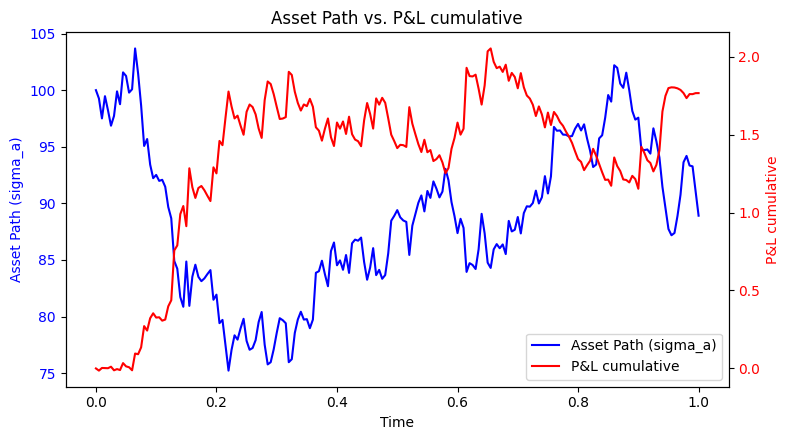

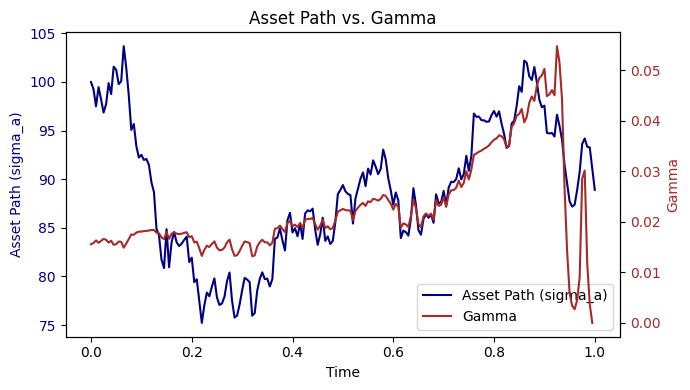

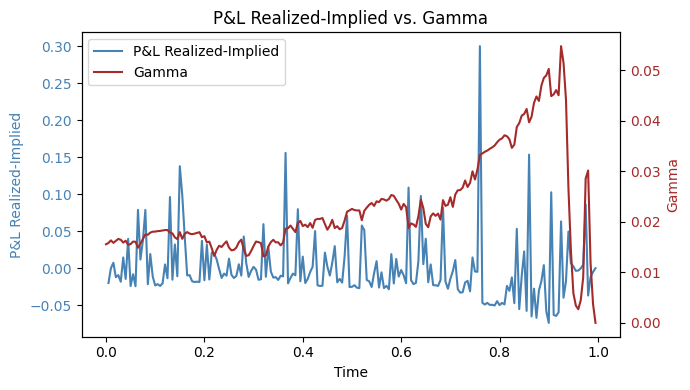

In [13]:
analyzer.plot_asset_vs_pl()
analyzer.plot_asset_vs_gamma()
analyzer.plot_realized_implied_vs_gamma()